# Week 13: Unsupervised Learning (Hierarchical clustering and DBSCAN)

```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>


```
In this lab, you will practice Clustering techniques

Lab Plan
1. Hierarchical clustering
2. DBSCAN
```

<hr>


![](https://miro.medium.com/max/1400/1*Ewg7z7YxEXbjECkHPdtrvA.png)

## 1. Hierarchical Clustering

We will compare between different types of linkage algorithm in different datasets.

#### Differences between Hierarchical clustering and KMeans:
1. Each run of KMeans on the same data is different, but in HC will be the same.
2. For hyper-spherical clusters shape, k-means works better.
3. Time complexity is proportional to the square of #points in HC while K-Means is linearly proportional.

---

## Data generation

In [ ]:
import time
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn import cluster
from sklearn.datasets import make_circles, make_blobs, make_moons
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Set random seed for reproducibility
np.random.seed(0)

# Define sample size
n_samples = 1500

# Generate synthetic datasets
noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)
no_structure = (np.random.rand(n_samples, 2), None)

# Generate anisotropic data
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Generate blobs with varied variances
varied = make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=random_state
)

## Agglomerative Hierarchical Clustering

**Steps in Agglomerative Hierarchical Clustering:**<br>
1. Start with individual points as clusters.
2. Compute pairwise distances between all clusters (i.e Euclidean distance, and a linkage criterion)
  - **Single Linkage**: Distance between the closest points in the two clusters.
  - **Complete Linkage**: Distance between the farthest points in the two clusters.
  - **Average Linkage**: Average distance between all points in the two clusters.
  - **Ward’s Linkage**: Minimizes the variance within clusters when merging.
3. Merge the two closest clusters.
4. Repeat steps 2 and 3 until all points are in a single cluster, or a predefined number of clusters is reached.
5. Visualize the process using a dendrogram.


### Comparing linkage algorithms


In [ ]:
from sklearn.cluster import AgglomerativeClustering
# Define color palette
COLORS = np.array(list(islice(cycle([
    '#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
    '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'
]), 10)))

# Default cluster parameters
default_base = {'n_clusters': 3}
datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {}),
    (aniso, {}),
    (blobs, {}),
    (no_structure, {})
]

# Utility function to create clustering algorithms
def get_clustering_algorithms(n_clusters):
    return [
        ('Single Linkage', AgglomerativeClustering(n_clusters=n_clusters, linkage='single')),
        ('Average Linkage', AgglomerativeClustering(n_clusters=n_clusters, linkage='average')),
        ('Complete Linkage', AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')),
        ('Ward Linkage', AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'))
    ]

# Set increased figure height and vertical spacing
rows = len(datasets)
cols = 4
subplot_height = 300  # Adjust this value to increase each subplot height
fig_height = rows * subplot_height

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=["Single Linkage", "Average Linkage", "Complete Linkage", "Ward Linkage"] * rows,
    vertical_spacing=0.03  # Adjust spacing as needed
)

for dataset_idx, (dataset, algo_params) in enumerate(datasets):
    # Update parameters with dataset-specific values
    params = {**default_base, **algo_params}
    X, _ = dataset
    X = StandardScaler().fit_transform(X)  # Normalize dataset

    for col_idx, (name, algorithm) in enumerate(get_clustering_algorithms(params['n_clusters'])):
        t0 = time.time()
        algorithm.fit(X)
        y_pred = algorithm.labels_.astype(int) if hasattr(algorithm, 'labels_') else algorithm.predict(X)
        t1 = time.time()

        # Add scatter plot to the figure
        fig.add_trace(
            go.Scatter(
                x=X[:, 0],
                y=X[:, 1],
                mode='markers',
                marker=dict(color=[COLORS[label % len(COLORS)] for label in y_pred], size=5),
                text=[f"Time: {t1 - t0:.2f}s" for _ in range(len(X))],
                showlegend=False
            ),
            row=dataset_idx + 1,
            col=col_idx + 1
        )

# Update layout with increased height
fig.update_layout(
    height=fig_height, width=1300,
    title_text="Agglomerative Clustering Comparison",
    title_x=0.5
)

# Display the figure
fig.show()

## Dendrogram

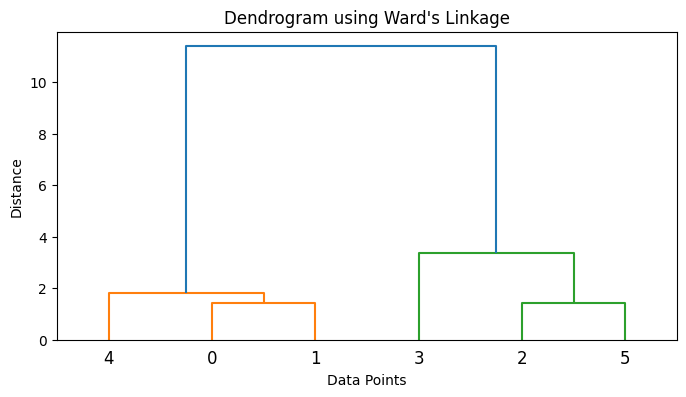

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward

# Example data
X = np.array([[1, 2], [2, 3], [6, 5], [8, 8], [1, 4], [7, 6]])

# Perform hierarchical clustering using Ward's linkage
linkage_matrix = ward(X)

# Plot the dendrogram
plt.figure(figsize=(8, 4))
dendrogram(linkage_matrix)
plt.title("Dendrogram using Ward's Linkage")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

## 4. DBSCAN

The main steps in the **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** algorithm are as follows:

1. **Label Each Point as Core, Border, or Noise**:
   - For each point in the dataset, count the number of points within a distance `eps` (epsilon). This defines the **neighborhood** of the point.
   - Classify each point as:
     - **Core Point**: If it has at least `min_samples` points within its `eps` neighborhood.
     - **Border Point**: If it’s not a core point but is within the neighborhood of a core point.
     - **Noise Point**: If it’s neither a core nor a border point (i.e., it has fewer than `min_samples` neighbors within `eps`).

2. **Form Clusters Around Core Points**:
   - Select an unvisited core point and start a new cluster with this point as the initial member.
   - Recursively add all points that are directly density-reachable from this core point (i.e., points within `eps` distance).
   - For each point added to the cluster, check if it’s a core point and, if so, repeat the process to find density-reachable points from that point.
   - Continue expanding the cluster until no more density-reachable points can be added.

3. **Process Remaining Points**:
   - Move to the next unvisited core point and form a new cluster following the same steps as above.
   - If the point is a border point or noise, mark it as visited without forming a new cluster.

4. **Identify Noise**:
   - After all core points are visited and clusters formed, any remaining points that were not added to a cluster are labeled as noise.

### Key Concepts in DBSCAN

- **Epsilon (`eps`)**: The maximum radius within which to search for neighboring points.
- **Min Points (`min_samples`)**: The minimum number of points (including the core point) required to form a dense region.
- **Density-Reachable**: A point `A` is density-reachable from point `B` if there is a chain of core points between them where each point lies within `eps` of the next.

### What's the pros and cons of DBSCAN?

<span style="color:blue">
Pros:

1. Discovers arbitrary shapes clusters
2. Robust towards outliers/noise

Cons:
1. Not efficient at clustering data with varying densities and sizes.
2. Sensitive to clustering params: minPoints & EPS
3. It doesn't scale good when the number of dimensions gets so big as the distance metric will converge to a constant value between any given examples.

In [ ]:
from sklearn.neighbors import kneighbors_graph

# Default parameters for clustering
default_base = {'quantile': .3, 'eps': .3, 'n_neighbors': 10, 'n_clusters': 3}
datasets = [
    (noisy_circles, {'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})
]

# Define figure parameters
rows = len(datasets)
cols = 2  # Two algorithms: KMeans and DBSCAN
subplot_height = 300
fig_height = rows * subplot_height

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=["KMeans", "DBSCAN"] * rows,
    vertical_spacing=0.04
)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # Update parameters with dataset-specific values
    params = {**default_base, **algo_params}
    X, _ = dataset
    X = StandardScaler().fit_transform(X)  # Normalize dataset

    # Connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)  # Make symmetric

    # Create clustering algorithms
    ms = cluster.KMeans(n_clusters=params['n_clusters'])
    dbscan = cluster.DBSCAN(eps=params['eps'])
    clustering_algorithms = [('KMeans', ms), ('DBSCAN', dbscan)]

    for col_idx, (name, algorithm) in enumerate(clustering_algorithms):
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        y_pred = algorithm.labels_.astype(int) if hasattr(algorithm, 'labels_') else algorithm.predict(X)

        # Define color map, with black for outliers (-1) in DBSCAN
        plot_colors = [COLORS[label % len(COLORS)] if label != -1 else "#000000" for label in y_pred]

        # Add scatter plot to the figure
        fig.add_trace(
            go.Scatter(
                x=X[:, 0],
                y=X[:, 1],
                mode='markers',
                marker=dict(color=plot_colors, size=5),
                text=[f"Time: {t1 - t0:.2f}s" for _ in range(len(X))],
                showlegend=False
            ),
            row=i_dataset + 1,
            col=col_idx + 1
        )

# Update layout with increased height
fig.update_layout(
    height=fig_height, width=1000,
    title_text="Clustering Comparison: KMeans vs. DBSCAN",
    title_x=0.5
)

# Display the figure
fig.show()


## Self Practice task

Using [UNSW-NB15 Dataset](https://www.dropbox.com/s/nsvgwps3abdoxnq/clustering_data.zip?dl=1):

1. Preprocess the dataset
2. Reduce dimension using PCA
3. Remove outliers
4. Cluster the data using Agglomerative Clustering, DBSCAN and Kmeans. Find the optimal number of clusters for each method
5. Visualize the data clusters (use PCA with 2 or 3 components)

Let's start!

I will read `projected_features.csv` file from the last lab cause I've already preprocessed data in this lab. Quick reminder. We have 27 features in our csv file

In [1]:
from numpy.random import choice
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy
from sklearn.datasets import make_blobs
import pandas as pd
import plotly.express as px

In [3]:
df = pd.read_csv('projected_features.csv')

If we are talking about classical K-means we can check previous lab. Cuase I've already implemented it. I will start with agglomerative clustering. As i made in my previous lab i know that we have 9 clusters here. that is why i will choose n_clusters = 9 


In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.utils import resample

df_sample = resample(df, n_samples=int(len(df) * 0.1), random_state=42)

linkages = ['ward', 'complete', 'average', 'single']

results = {}

for linkage in linkages:

    if linkage == 'ward':
        model = AgglomerativeClustering(n_clusters=9, linkage=linkage)
    else:
        # i add it if you want to cnahge metric cause for ward linkage we can apply only euclidean distance
        model = AgglomerativeClustering(n_clusters=9, metric = 'euclidean', linkage=linkage)

    y = model.fit_predict(df_sample)

    silhouette = silhouette_score(df_sample,y)
    calinski_harabasz = calinski_harabasz_score(df_sample, y)

    results[linkage] = {
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Index": calinski_harabasz,
    }

    print(f"Linkage: {linkage}, Silhouette Score: {silhouette:.3f}, Calinski-Harabasz Index: {calinski_harabasz:3f}\n")



print("Summary of Results:")
for linkage, metrics in results.items():
    print(f"Linkage: {linkage}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.3f}")


Linkage: ward, Silhouette Score: 0.544, Calinski-Harabasz Index: 148173.219063

Linkage: complete, Silhouette Score: 0.541, Calinski-Harabasz Index: 164182.402852

Linkage: average, Silhouette Score: 0.536, Calinski-Harabasz Index: 161137.885583

Linkage: single, Silhouette Score: 0.245, Calinski-Harabasz Index: 44967.718910

Summary of Results:
Linkage: ward
  Silhouette Score: 0.544
  Calinski-Harabasz Index: 148173.219
Linkage: complete
  Silhouette Score: 0.541
  Calinski-Harabasz Index: 164182.403
Linkage: average
  Silhouette Score: 0.536
  Calinski-Harabasz Index: 161137.886
Linkage: single
  Silhouette Score: 0.245
  Calinski-Harabasz Index: 44967.719


**The higher result of Calinski-Harabasz Index is better cause it indicates that data points are more spread out between cluster than they are within clusters**

Let's built dendogram for the linkage with a best results - `WARD'S LINKAGE`

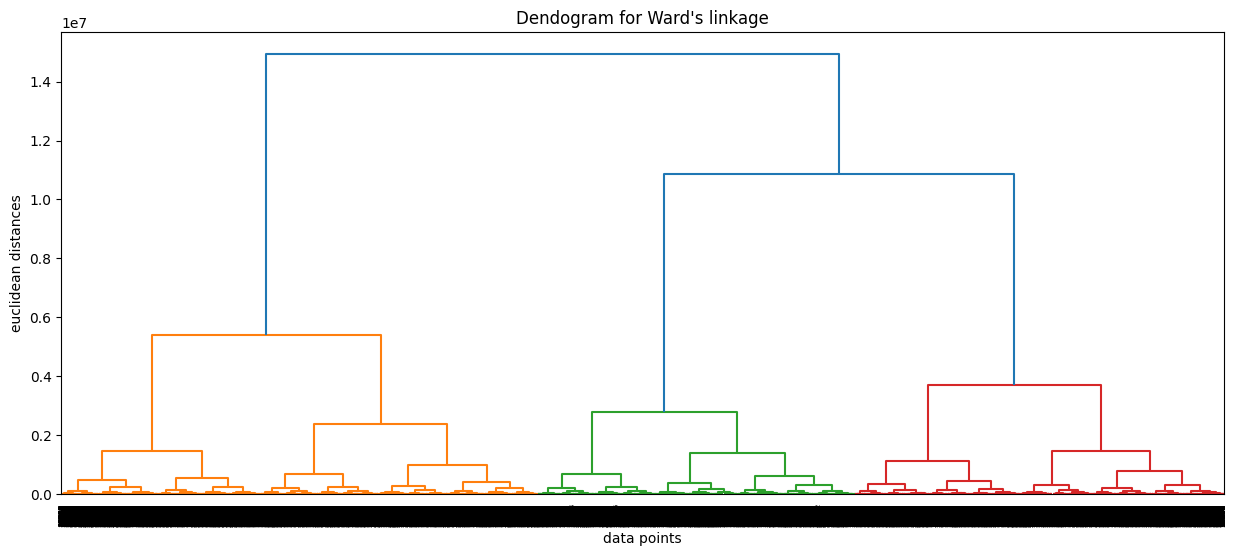

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage 

plt.figure(figsize=(15,6))
plt.title("Dendogram for Ward's linkage")
plt.xlabel("data points")
plt.ylabel("euclidean distances")

link_matrix = linkage(df_sample, method='ward')
dendrogram = dendrogram(link_matrix)
plt.savefig("dendogram_1.png")
plt.show()

Next step is to show the result in 2D. I will use same function I used in my previous lab. I will just copy and paste without any additional axplanation

In [ ]:
from sklearn.cluster import KMeans

# Function to plot 2D clusters for different numbers of clusters
def plot_clusters_2d(features_scaled, cluster_sizes):
    fig, axes = plt.subplots(
        len(cluster_sizes), 1, figsize=(9, 12)
    )  # Vertical arrangement

    for i, n_clusters in enumerate(cluster_sizes):
        # 1. Perform PCA to reduce the features to 2D
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features_scaled)

        # 2. Fit KMeans with the specified number of clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_features)

        # 3. Plot the 2D scatter plot for the current number of clusters
        scatter = axes[i].scatter(
            reduced_features[:, 0],
            reduced_features[:, 1],
            c=cluster_labels,
            cmap="tab20",  # Changed colormap for better color distinction
            s=40,  # Adjusted marker size
            alpha=0.6,  # Adjusted opacity for better overlap handling
        )
        
        # 4. Plot the cluster centers
        centers = kmeans.cluster_centers_
        axes[i].scatter(
            centers[:, 0],
            centers[:, 1],
            c="black",  # Cluster centers in black
            marker="x",
            s=100,
            label="Cluster Centers"
        )

        axes[i].set_title(f"{n_clusters} Clusters")
        axes[i].set_xlabel("PCA Component 1")
        axes[i].set_ylabel("PCA Component 2")
        axes[i].grid(True)

        # Add color legend for cluster labels
        fig.colorbar(scatter, ax=axes[i], orientation='vertical', label="Cluster ID")

    plt.tight_layout()
    plt.show()


# Define the cluster sizes for which you want to visualize the clusters
cluster_sizes = [9, 11]

# Assuming features_scaled is your feature matrix
plot_clusters_2d(projected_features_df, cluster_sizes)